In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
first_df = pd.read_csv('Data/RFP/2025_04_24.csv')
second_df = pd.read_csv('Data/RFP/2025_04_24_secondmeasurement.csv')
third_df = pd.read_csv('Data/RFP/2025_04_24_thirdmeasurement.csv')

In [3]:
first_df['Rep'] = 1
second_df['Rep'] = 2
third_df['Rep'] = 3

df = pd.concat([first_df, second_df, third_df], ignore_index=True)
df = df.sort_values(by=['EC#'], ignore_index=True)
df.head(10)

,EC#,Strain,Sequence_infill,Sequence,Avg_OD600,Avg_GFP,Avg_RFP,Rel_RFP,Rep
0,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,AATACTAGAGGTCTTCCGACTCCGGGCGCTATCATGCCATACCGCG...,0.178331,5.155400e+05,5791.166670,32474,1
1,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT,AATACTAGAGGTCTTCCGACTCCGGGCGCTATCATGCCATACCGCG...,0.340217,5.909457e+05,7450.333333,21899,2
2,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAA...,0.295065,7.084137e+05,138717.833300,470127,2
3,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAA...,0.091953,4.463880e+05,64155.166700,697698,1
4,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAA...,0.163669,1.391900e+05,353329.667000,2158810,1
5,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA,AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAA...,0.362198,2.659952e+05,349778.333300,965711,2
6,36,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,0.069388,1.902548e+06,126919.167000,1829128,1
7,36,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,0.264411,4.508661e+06,245599.833300,928857,2
8,37,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,0.277999,4.889728e+06,459233.333300,1651925,2
9,37,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,0.084288,2.120625e+06,221796.167000,2631408,1


In [5]:
# get minimum length of df['Sequence_infill]

min_length = df['Sequence_infill'].str.len().min()
print(f'Minimum length of Sequence_infill: {min_length}')

Minimum length of Sequence_infill: 34


### Fit Linear Regression to find best lengths upstream and downstream of the TSS
---

In [27]:
# The minimum insert length is 34, so 116 is the maximum length of either flanking sequence.

upstream = 'TTTGTGCCCATTAACATCACCATCTAATTCAACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCATCTAGTATTTCTCCTCTTTAATACTAGAGGTCTTCCGAC'
downstream = 'GCGGGAAGACAACTAGGGGCCCAAGTTCACTTAAAAAGGAGATCAACAATGAAAGCAATTTTCGTACTGAAACATCTTAATCATGCGACGGAGCGTTTCTAATGGCTTCCTCCGAA'

max_flank_length = 116 

In [31]:
CNN_5_0 = keras.saving.load_model('Models/CNN_5_0.keras')
CNN_5_1 = keras.saving.load_model('Models/CNN_5_1.keras')
CNN_5_6 = keras.saving.load_model('Models/CNN_5_6.keras')
CNN_6_1_2 = keras.saving.load_model('Models/CNN_6_1_2.keras')

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
        encoding += [mapping[nucleotide]]
    return encoding

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

metrics_data = {
    'upstream_length': [],
    'downstream_length': [],
    'mse': [],
    'r2': [],
}

df['Sequence_infill'] = df['Sequence_infill'].str.replace('_', '')
df['log_Rel_RFP'] = np.log(df['Rel_RFP'])

for upstream_length in range(max_flank_length):
    for downstream_length in range(max_flank_length):

        print(f"{upstream_length}, {downstream_length}", end='\r')

        if upstream_length + downstream_length > max_flank_length:
            continue

        for idx, row in df.iterrows():
            infill = row['Sequence_infill']
            infill += downstream[:downstream_length]
            upstream_to_add = upstream[len(upstream) - (upstream_length - len(infill)):]
            sequence = upstream_to_add + infill

            # make sure the sequence is not longer than 150 characters
            if len(sequence) > 150:
                sequence = sequence[:150]

            # replace the sequence in the dataframe
            df.at[idx, 'Sequence'] = sequence
        
        # predict the RFP values using the CNN model
        sequences = np.array([padded_one_hot_encode(seq.zfill(150)) for seq in df['Sequence']])
        df['CNN_6_1_2_Pred_RFP'] = CNN_6_1_2.predict(sequences, verbose=0).flatten()

        # fit a linear regression model between the predicted RFP values and the actual RFP values
        X = df['CNN_6_1_2_Pred_RFP'].values.reshape(-1, 1)
        y = df['log_Rel_RFP'].values.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        metrics_data['upstream_length'].append(upstream_length)
        metrics_data['downstream_length'].append(downstream_length)
        metrics_data['mse'].append(mean_squared_error(y, y_pred))
        metrics_data['r2'].append(r2_score(y, y_pred))

In [77]:
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values(by=['mse'], ascending=False)
metrics_df

,upstream_length,downstream_length,mse,r2
5582,66,6,2.375318,0.000002
4204,44,3,2.375316,0.000002
5473,64,2,2.375301,0.000009
5366,62,4,2.375270,0.000022
4953,55,4,2.375243,0.000033
...,...,...,...,...
6158,78,36,0.806802,0.660340
6077,76,36,0.803002,0.661940
5699,68,22,0.802491,0.662155
6197,79,36,0.790183,0.667336


In [78]:
metrics_df.to_csv('Data/RFP/linregress_metrics_df.csv', index=False)

In [60]:
color_map = {
    'pClone_GFP' : 'blue',
    'Lac' : 'blue',
    'OsmY' : 'blue',
    'OsmY_C12A' : 'blue',
    'P5' : 'blue',
    'P533A' : 'blue',

    'high_dG (low_expr)' : 'red',
    'low_dG (high_expr)' : 'red',
    'med_dG (med_expr)' : 'red',

    'p125' : 'green',
    'p250' : 'green',
    'p375' : 'green',
    'p500' : 'green',
    'p600' : 'green',
    'p625' : 'green',
    'p650' : 'green',
    'p750' : 'green', 
    'p800' : 'green',
    'p875' : 'green',

    'p1000 (del_22A)' : 'orange',
    'p1000 (del_23T)' : 'orange',
    'p700 (del_21C)' : 'orange',
    'p750 (del_19T)' : 'orange',
    'p750 (del_22A)' : 'orange', 
}

Upstream length: 66, Downstream length: 6


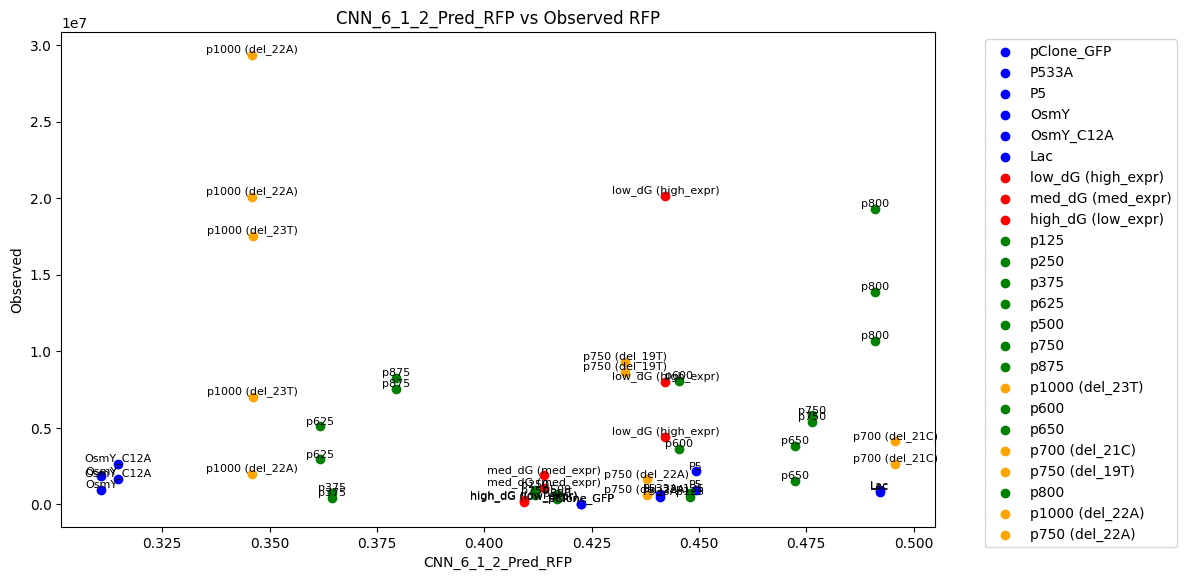

Upstream length: 44, Downstream length: 3


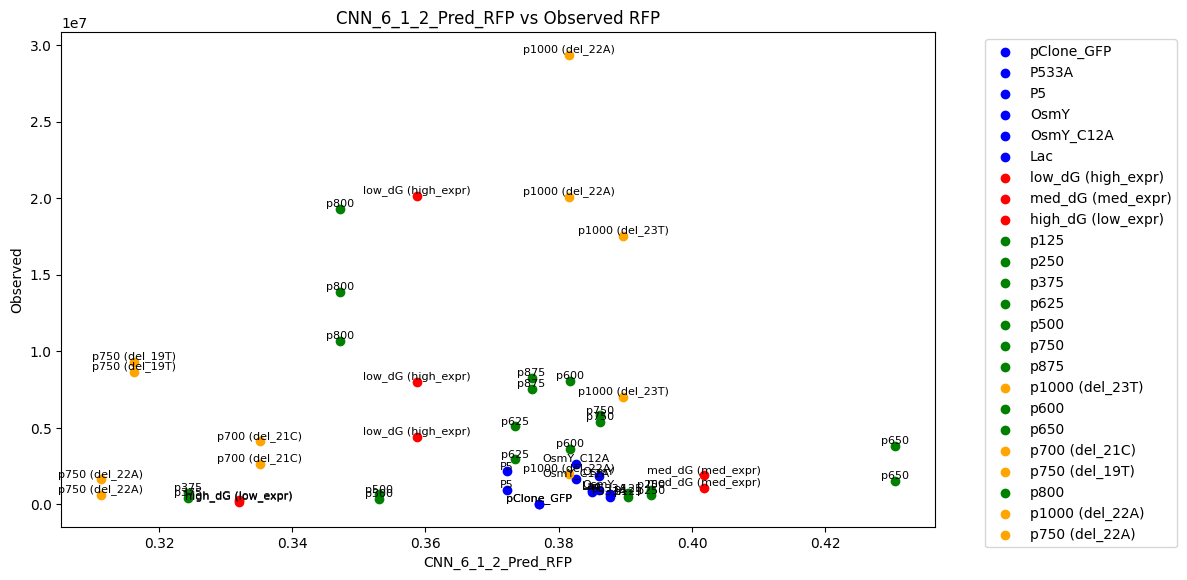

Upstream length: 64, Downstream length: 2


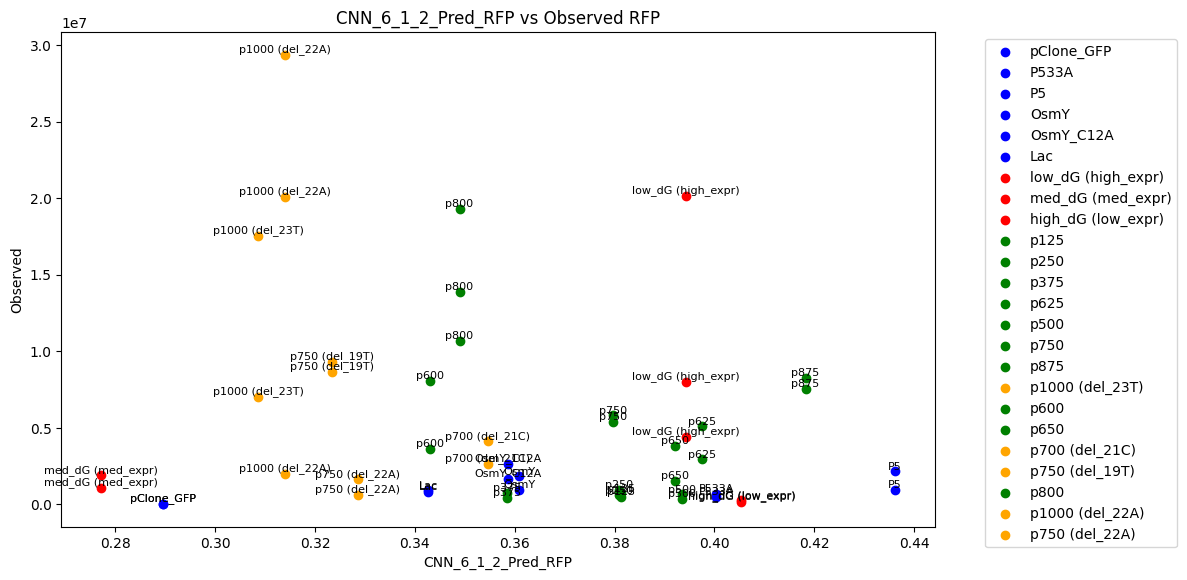

Upstream length: 62, Downstream length: 4


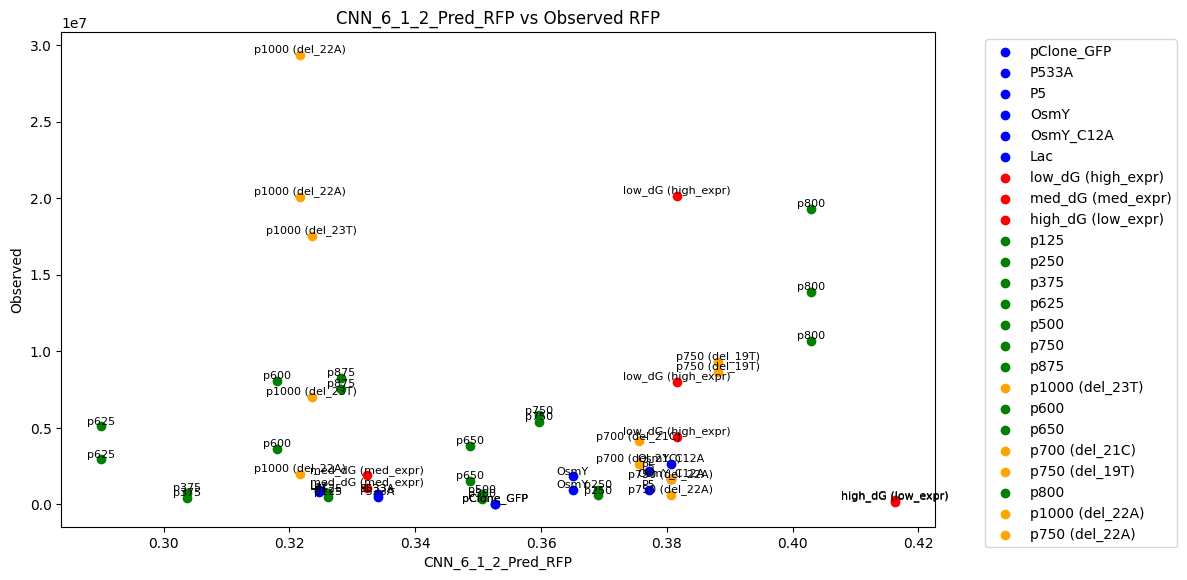

Upstream length: 55, Downstream length: 4


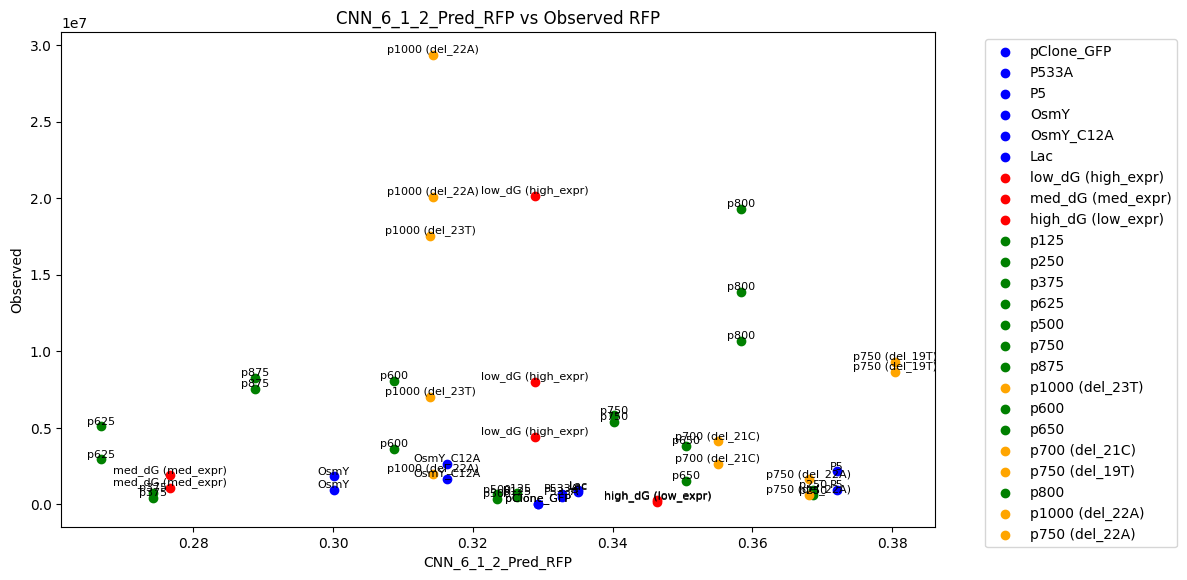

Upstream length: 62, Downstream length: 2


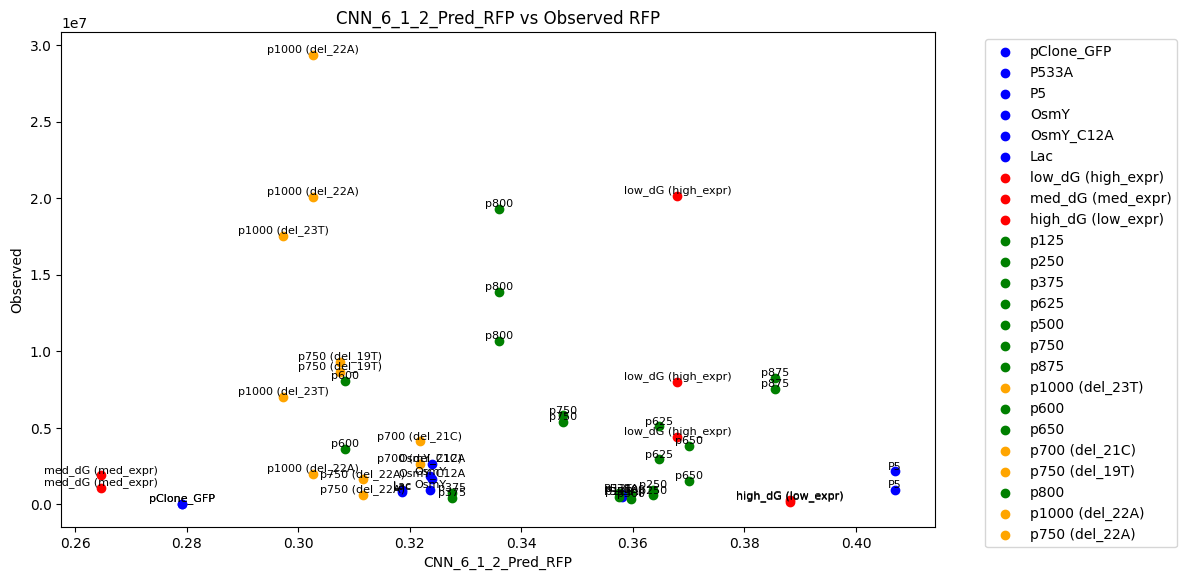

Upstream length: 65, Downstream length: 4


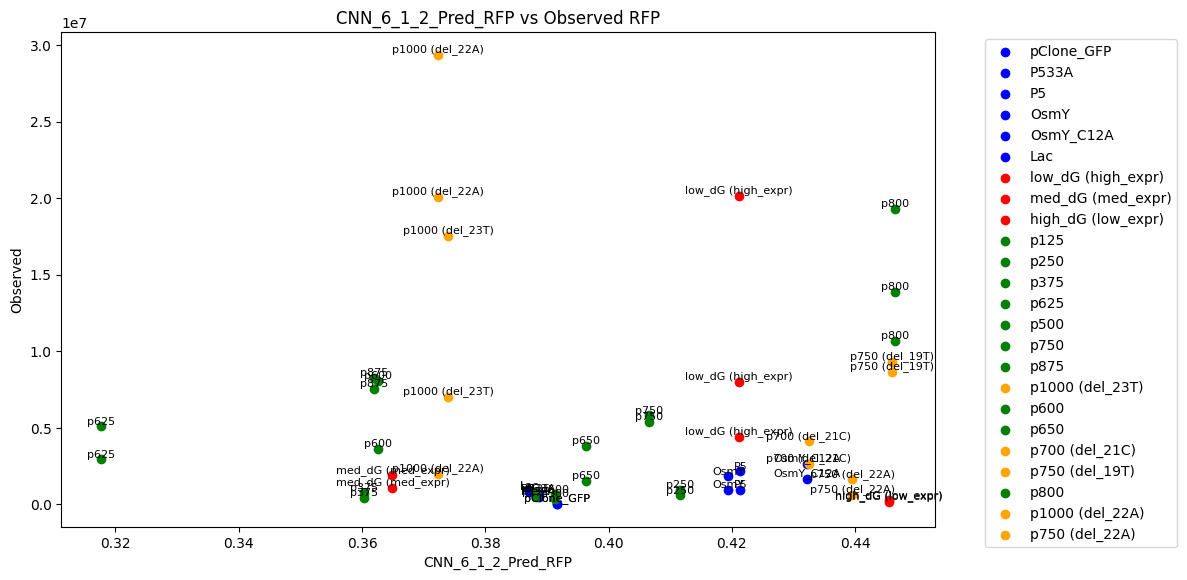

Upstream length: 45, Downstream length: 3


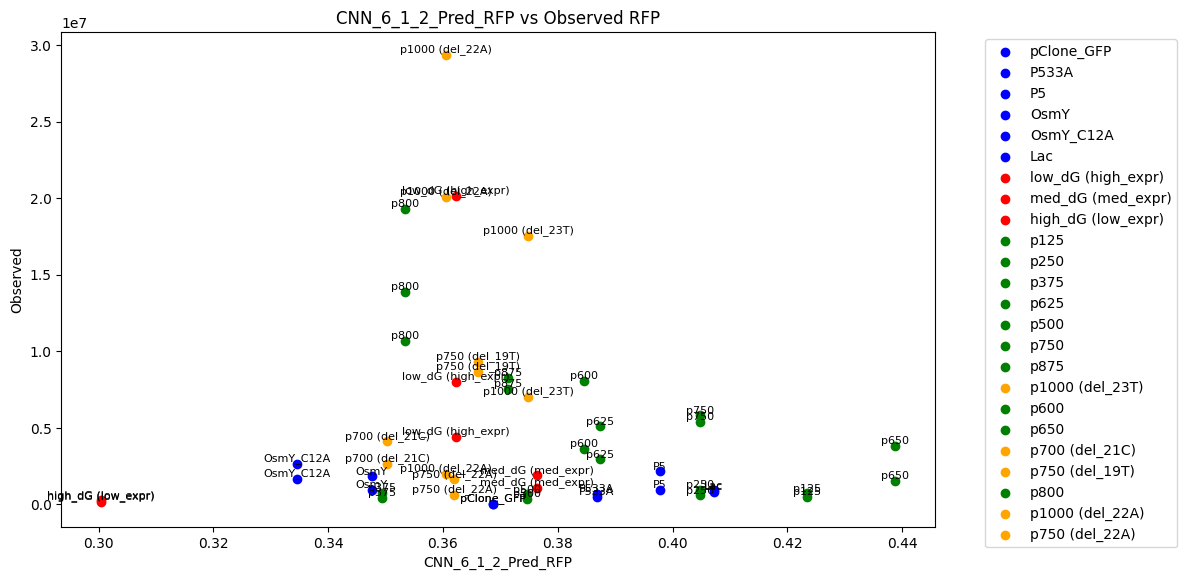

Upstream length: 7, Downstream length: 90


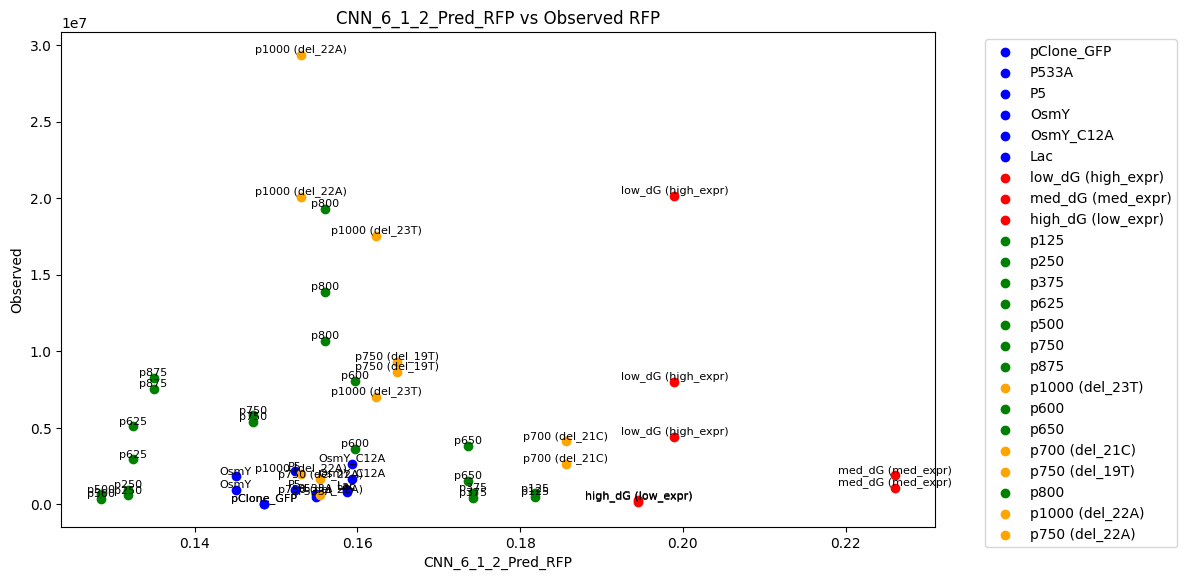

Upstream length: 4, Downstream length: 90


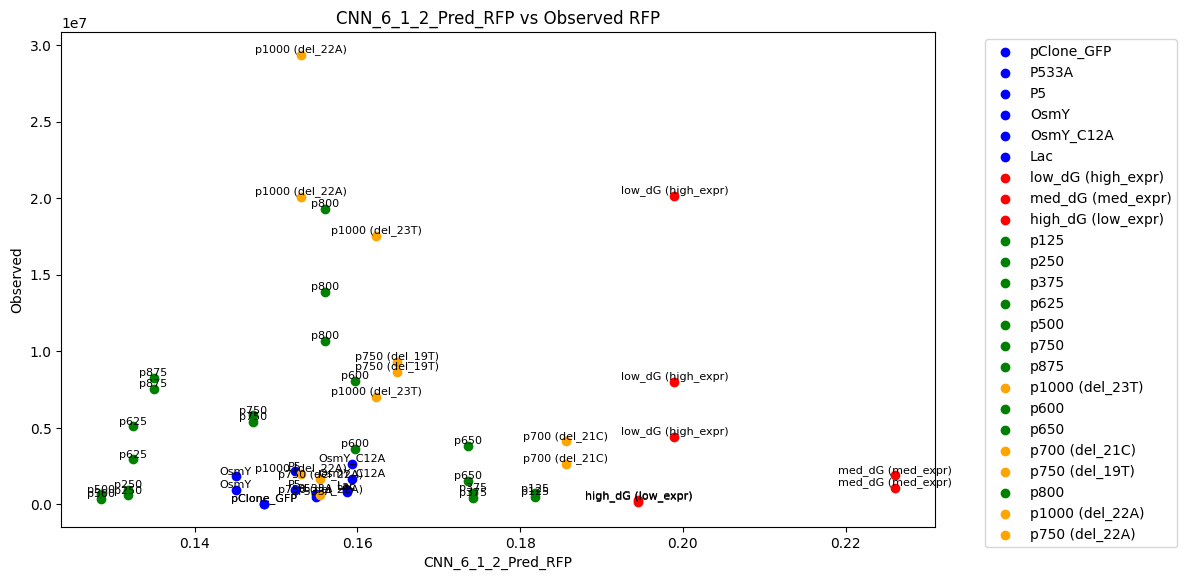

In [79]:
for idx, row in metrics_df.head(10).iterrows():

    upstream_length = int(row['upstream_length'])
    downstream_length = int(row['downstream_length'])

    print(f"Upstream length: {upstream_length}, Downstream length: {downstream_length}")

    for idx, row in df.iterrows():
        infill = row['Sequence_infill']
        infill += downstream[:downstream_length]
        upstream_to_add = upstream[len(upstream) - (upstream_length - len(infill)):]
        sequence = upstream_to_add + infill

        # make sure the sequence is not longer than 150 characters
        if len(sequence) > 150:
            sequence = sequence[:150]

        # replace the sequence in the dataframe
        df.at[idx, 'Sequence'] = sequence

    # predict the RFP values using the CNN model
    sequences = np.array([padded_one_hot_encode(seq.zfill(150)) for seq in df['Sequence']])
    df['CNN_6_1_2_Pred_RFP'] = CNN_6_1_2.predict(sequences, verbose=0).flatten()

    plt.figure(figsize=(12, 6))

    for promoter in df['Strain'].unique():
        subset = df[df['Strain'] == promoter]
        color = color_map[promoter]
        plt.scatter(subset['CNN_6_1_2_Pred_RFP'], subset['Rel_RFP'], c=[color], label=promoter)

    plt.xlabel('CNN_6_1_2_Pred_RFP')
    plt.ylabel('Observed')
    plt.title('CNN_6_1_2_Pred_RFP vs Observed RFP')

    for row in df.iterrows():
        plt.text(row[1]['CNN_6_1_2_Pred_RFP'], row[1]['Rel_RFP'], row[1]['Strain'], fontsize=8, ha='center', va='bottom')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()